In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

# 0. Folder creation

In [2]:
%%bash
#Structured mesh should be on str_uns/structuredMesh 

#Main conversion directory
if [ ! -d "str_uns" ]; then
  mkdir str_uns
fi

#It should ensure that the structured mesh exists
if [ ! -d "str_uns/structuredMesh" ]; then
    echo "NON STRUCTURED MESH to convert"
    exit 0
fi

#If the directory of a previous unstructured mesh exists it will remove
if [ -d "str_uns/unstructuredMesh" ]; then
  rm str_uns/unstructuredMesh -r
  cp str_uns/structuredMesh str_uns/unstructuredMesh -r
fi

#If the directory does not exists
if [ ! -d "str_uns/unstructuredMesh" ]; then
  cp str_uns/structuredMesh str_uns/unstructuredMesh -r
fi

# 1. Data input - point adquisition

In [3]:
filename = './str_uns/structuredMesh/constant/polyMesh/points'
file = open(filename, "r")
points_str = file.read()

i = 2
pointsNo = 0

while points_str[points_str.find('(')-i] != '\n':
    if i == 2:
        pointsNo = int(points_str[points_str.find('(')-i])
    else:
        pointsNo = pointsNo + int(points_str[points_str.find('(')-i]) * 10**(i-2)
    i += 1
    
points = np.zeros((pointsNo, 3))

In [4]:
arrayPos = 0
tempPos = 0
negVal = 0
decimal = 0
engExp = 0

for i in range(points_str.find('(')+1, len(points_str)):
    #First element of each line resets the temporal points
    if points_str[i] == '(':
        tempPoints = np.zeros(3)
    #End element of each line transfer the elements to the big array, resets tempPos and advance 1 in arrayPos
    elif points_str[i] == ')':
        points[arrayPos,:] = tempPoints
        arrayPos += 1
        tempPos = 0
    #An space will do nothing for the moment!
    elif points_str[i] == ' ' :
        pass;
    #New line will do nothing! - except if it arrives to the end of the string it will encounter ) \n ) 
    elif points_str[i] == '\n':
        if points_str[i-1] == ')' and points_str[i] == '\n' and points_str[i+1] == ')':
            break;
    #Minus sign will do nothing (for the moment!)
    elif points_str[i] == '-':
        if engExp == 0:
            negVal = 1
    #Period will do nothing (for the moment!)
    elif points_str[i] == '.':
        decimal = 1;
    #Engineering notation
    elif points_str[i] == 'e':
        if points_str[i+1] == '-':
            engExp = - (10 * int(points_str[i+2]) + int(points_str[i+3]))
        else:
            engExp = (10 * int(points_str[i+2]) + int(points_str[i+3]))
    #If the element is a number...
    else:
        if engExp == 0:            
            #if it is zero we are still on the natural part of the number
            if decimal == 0:    
                tempPoints[tempPos] = 10*tempPoints[tempPos]+int(points_str[i])
            #if the decimal variable is not zero
            if decimal >= 1:
                #If the next element of the string is a space or a ), the number will be completed
                if points_str[i+1] == ' ' or points_str[i+1] == ')':
                    tempPoints[tempPos] = tempPoints[tempPos]+int(points_str[i])*10**(-decimal)
                    decimal = 0
                #If it is a number
                else: 
                    tempPoints[tempPos] = tempPoints[tempPos]+int(points_str[i])*10**(-decimal)
                    decimal += 1
            #If the next element is a space...
            if points_str[i+1] == ' ' :
                #... and a negative sign was found, it should multiply now by -1 and advance one position...
                if negVal == 1:
                    tempPoints[tempPos] *= -1
                    tempPos += 1
                    negVal = 0
                #... otherwise it will just advance one position
                else:
                    tempPos += 1
        else:
            if points_str[i+1] == ' ' :
                #... and a negative sign was found, it should multiply now by -1 and advance one position...
                if negVal == 1:
                    tempPoints[tempPos] *= -1*10**(engExp)
                    tempPos += 1
                    negVal = 0
                    engExp = 0
                #... otherwise it will just advance one position
                else:
                    tempPoints[tempPos] *= -1*10**(engExp)
                    tempPos += 1 
                    engExp = 0

# 2. Grid conversion

In [12]:
#Bounding box to perform the unstructured grid - if other one is wanted, please specify!!
#Xmax = np.max(points[:,0])
#Xmin = np.min(points[:,0])
Ymax = np.max(points[:,1])
Ymin = np.min(points[:,1])
Zmax = np.max(points[:,2])
Zmin = np.min(points[:,2])

Xmax = 10
Xmin = 1
#Ymax = 
#Ymin = 
#Zmax = 
#Zmin = 

#Distance factor to restrict the maximum displacement of the points - defined between [0,0.1] for better results
k = 0.008

unstrPoints = np.copy(points)
frontPoints = points[:,2] == Zmin
backPoints = points[:,2] == Zmax

In [13]:
#Shape of the front and back plane should be the same
np.shape(points[frontPoints,:]) == np.shape(points[backPoints,:])

True

In [14]:
for i in np.nditer(np.where(frontPoints)):
    #If the point is between bounds
    if points[i,0] > Xmin and points[i,0] < Xmax and points[i,1] > Ymin and points[i,1] < Ymax:
        #compute the distance from every point to point i analyzed, retaining just the 8 closest (4 front, 4 back) - neglecting the same point
        vec = np.sqrt((points[:,0]-points[i,0])**2+(points[:,1]-points[i,1])**2).argsort()[2:10]
        #obtain the backPlane point which corresponds to the frontPlane one
        if np.sqrt((points[:,0]-points[i,0])**2+(points[:,1]-points[i,1])**2).argsort()[1] == i:
            backPoint = np.sqrt((points[:,0]-points[i,0])**2+(points[:,1]-points[i,1])**2).argsort()[0]  
        else:
            backPoint = np.sqrt((points[:,0]-points[i,0])**2+(points[:,1]-points[i,1])**2).argsort()[1]
        #separate them between front and back plane
        frontVec = vec[points[vec,2] == Zmin]
        #the limits of the zone in which point i can move are
        maxX = max(points[frontVec,0])
        maxY = max(points[frontVec,1])
        minX = min(points[frontVec,0])
        minY = min(points[frontVec,1])
        #let's compute the variation in both x and y axis
        varX = np.random.triangular(-k*abs(minX-points[i,0]), 0, k*abs(maxX-points[i,0]), 1)
        varY = np.random.triangular(-k*abs(minY-points[i,0]), 0, k*abs(maxY-points[i,0]), 1)
        #Let's store the points in the array
        unstrPoints[i,0] = points[i,0]+varX
        unstrPoints[i,1] = points[i,1]+varY
        unstrPoints[backPoint,0] = points[backPoint,0]+varX
        unstrPoints[backPoint,1] = points[backPoint,1]+varY

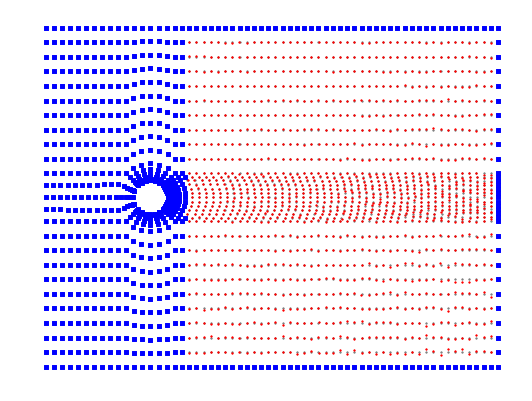

In [15]:
fig, ax1 = plt.subplots(1, figsize=(13,10), dpi = 50)

#above and below points
for i in np.nditer(np.where(frontPoints)):
    if points[i,0] > Xmin and points[i,0] < Xmax and points[i,1] > Ymin and points[i,1] < Ymax:
        ax1.scatter(points[i,0], points[i,1], color='grey', s=5)
    else:
        ax1.scatter(points[i,0], points[i,1], color='blue', marker = 's')
    if unstrPoints[i,0] > Xmin and unstrPoints[i,0] < Xmax and unstrPoints[i,1] > Ymin and unstrPoints[i,1] < Ymax:
        ax1.scatter(unstrPoints[i,0], unstrPoints[i,1], color='red', s=5)
    else:
        ax1.scatter(unstrPoints[i,0], unstrPoints[i,1], color='blue', marker = 's')
ax1.axis('off');

# 3. Point saving

In [16]:
%%bash
rm ./str_uns/unstructuredMesh/constant/polyMesh/points
rm ./str_uns/unstructuredMesh/constant/polyMesh/str_uns -r

rm: cannot remove './str_uns/unstructuredMesh/constant/polyMesh/str_uns': No such file or directory


In [17]:
with open('./str_uns/unstructuredMesh/constant/polyMesh/points', 'a') as uPF: #unstructuredPointFile
    uPF.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
    uPF.write('| =========                 |                                                 | \n')
    uPF.write('| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    uPF.write('|  \\    /   O peration     | Version:  5.x                                   | \n')
    uPF.write('|   \\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
    uPF.write('|    \\/     M anipulation  |                                                 | \n')
    uPF.write('\*---------------------------------------------------------------------------*/ \n')
    uPF.write('FoamFile \n')
    uPF.write('{ \n')
    uPF.write('    version     2.0; \n')
    uPF.write('    format      ascii; \n')
    uPF.write('    class       vectorField; \n')
    uPF.write('    location    "constant/polyMesh"; \n')
    uPF.write('    object      points; \n')
    uPF.write('} \n')
    uPF.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * // \n')
    uPF.write('\n')
    uPF.write('%i \n' %(pointsNo))
    uPF.write('(')
    for i in range(pointsNo):
        uPF.write('(%.6f %.6f %.6f) \n' %(unstrPoints[i,0], unstrPoints[i,1], unstrPoints[i,2]))        
    uPF.write(')')

In [18]:
%%bash
cd str_uns/unstructuredMesh/
checkMesh >/dev/null
paraFoam

Created temporary 'unstructuredMesh.OpenFOAM'
Qt: Cannot set locale modifiers: 
I/O    : uncollated
